<a href="https://colab.research.google.com/github/ImJongHwan/practice-ml-nlp/blob/main/10_text_classification_using_rnn/8_BiLSTM_Steam_Korean_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiLSTM으로 한국어 스팀 리뷰 감성 분류하기

https://wikidocs.net/94748

## Colab에 Mecab 설치

In [1]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [3]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.

## 스팀 리뷰 데이터에 대한 이해와 전처리

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7f7f6456b890>)

In [6]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [7]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [8]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

In [9]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [10]:
print(total_data.isnull().values.any())

False


In [11]:
# 훈련 데이터와 테스트 데이터 분리하기
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


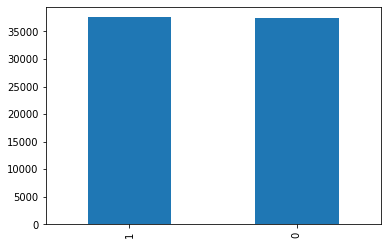

In [12]:
# 레이블의 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [13]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


In [14]:
# 데이터 정제하기
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


label      0
reviews    0
dtype: int64


In [15]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


전처리 후 테스트용 샘플의 개수 : 24973


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [17]:
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [19]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3653), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [20]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4354), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948459100231734
부정 리뷰의 평균 길이 : 15.284193065068493


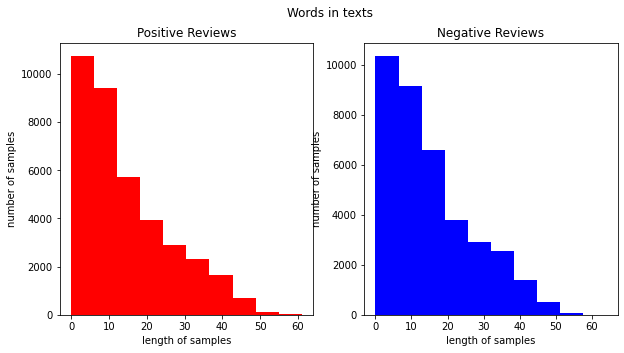

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [22]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [23]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [24]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32817
등장 빈도가 1번 이하인 희귀 단어의 수: 13878
단어 집합에서 희귀 단어의 비율: 42.28905750068562
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2254607619437832


In [25]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18941


In [26]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
print(X_train[:3])

[[495, 7, 35, 87, 149, 2429, 599, 26, 8, 70, 47, 235, 111, 38, 44, 52], [161, 300, 18, 20, 63, 3582, 985, 6, 56], [7, 17, 1476, 4]]


In [28]:
print(X_test[:3])

[[728, 34, 16, 431, 52, 106, 132, 99, 6461, 453], [4527, 687, 835, 712, 792, 108, 4, 1779, 95, 370, 3519, 81, 558, 1904, 4189, 262, 169, 61, 25, 363, 35, 87, 974, 19, 6294, 6422], [1792, 806, 685, 49, 23, 349]]


리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115951894712957


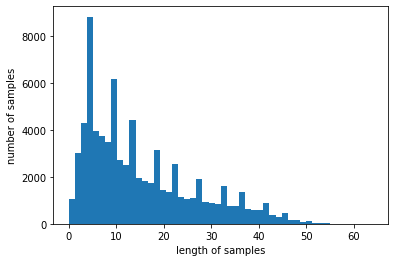

In [29]:
# 패딩
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [31]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99599567532935


In [32]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## BiLSTM으로 스팀 리뷰 감성 분류하기

In [33]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5225 - acc: 0.7463
Epoch 1: val_acc improved from -inf to 0.78497, saving model to best_model.h5
235/235 [==============================] - 203s 835ms/step - loss: 0.5225 - acc: 0.7463 - val_loss: 0.4655 - val_acc: 0.7850
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4324 - acc: 0.8033
Epoch 2: val_acc did not improve from 0.78497
235/235 [==============================] - 184s 781ms/step - loss: 0.4324 - acc: 0.8033 - val_loss: 0.4788 - val_acc: 0.7772
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4065 - acc: 0.8189
Epoch 3: val_acc improved from 0.78497 to 0.78784, saving model to best_model.h5
235/235 [==============================] - 181s 772ms/step - loss: 0.4065 - acc: 0.8189 - val_loss: 0.4621 - val_acc: 0.7878
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3858 - acc: 0.8297
Epoch 4: val_acc improved from 0.78784 to 0.78958, savin

In [34]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 27s 33ms/step - loss: 0.4668 - acc: 0.7891
테스트 정확도: 0.7891


## 리뷰 예측하기

In [35]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [36]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

96.44% 확률로 부정 리뷰입니다.


In [37]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

98.07% 확률로 긍정 리뷰입니다.


In [38]:
sentiment_predict('케릭터가 예뻐서 좋아요')

92.11% 확률로 긍정 리뷰입니다.
